In [1]:
from cil.framework import BlockDataContainer, ImageGeometry
from cil.optimisation.operators import BlockOperator, IdentityOperator
import numpy as np
from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.plugins.ccpi_regularisation.functions.regularisers import  RegulariserFunction
from cil.plugins.ccpi_regularisation.functions import  FGP_TV
from cil.optimisation.functions import Function

### TV Proximal For BlockDataContainers

- We start with a BlockDataContainer
- We make it a CIL ImageData
- Apply FGP_TV in real and imaginary
- Get a CIL DataContainer
- Make it a BlockDataContainer
- Continue with FISTA


### From BlockDataContainer to ImageData as an array

In [2]:
class BDCToID():
    
    def __init__(self, bdc):
        
        self.bdc = bdc
        
        # check that all datacontainers have the same shape
        all_shape = [i.shape for i in bdc.containers]
        num_containers = len(bdc.containers)
        if len(set(all_shape))>1:
            raise ValueError("Different shapes for containers")            
        if len(bdc[0].shape)==2:
            y, x = bdc[0].shape
            self.ig = ImageGeometry(voxel_num_y = y, voxel_num_x = x, channels=num_containers)
        elif len(bdc[0].shape)==3:            
            z,y,x = bdc[0].shape
            self.ig = ImageGeometry(voxel_num_z = z, voxel_num_y = y, voxel_num_x = x, 
                                    channels=num_containers)
        else:
            raise ValueError("not implemented")
            
        self.id_cil = self.ig.allocate(dtype=bdc[0].dtype)
        print(self.id_cil.dtype)

            
    def IDarray(self):
        
        tmp = np.stack([i.array for i in self.bdc], axis=0)
        self.id_cil.fill(tmp)
        return self.id_cil

In [3]:
print("For three 2D ImageDataContainers ")    

# create image geometry
ig2D = ImageGeometry( voxel_num_y=3, voxel_num_x=4)

# create image data
x0_2D = ig2D.allocate('random')
x1_2D = ig2D.allocate('random')
x2_2D = ig2D.allocate('random')

# create bdc
bdc = BlockDataContainer(x0_2D,x1_2D,x2_2D)


# blockdatacontainer to ImageData
bdctoid = BDCToID(bdc)

new_id3D = bdctoid.IDarray()

print("Shape for every DataContainer in a BlockDataContainer {}".format([i.shape for i in bdc.containers]))
print("Shape of the new ImageData is {}".format(new_id3D.shape))

For three 2D ImageDataContainers 
float32
Shape for every DataContainer in a BlockDataContainer [(3, 4), (3, 4), (3, 4)]
Shape of the new ImageData is (3, 3, 4)


In [4]:
print("For three 3D ImageDataContainers ")    

# create image geometry
ig3D = ImageGeometry( voxel_num_z = 5, voxel_num_y=3, voxel_num_x=4)

# create image data
x0_3D = ig3D.allocate('random')
x1_3D = ig3D.allocate('random')
x2_3D = ig3D.allocate('random')

# create bdc
bdc = BlockDataContainer(x0_3D,x1_3D,x2_3D)


# blockdatacontainer to ImageData
bdctoid = BDCToID(bdc)

new_id4D = bdctoid.IDarray()

print("Shape for every DataContainer in a BlockDataContainer {}".format([i.shape for i in bdc.containers]))
print("Shape of the new ImageData is {}".format(new_id4D.shape))



For three 3D ImageDataContainers 
float32
Shape for every DataContainer in a BlockDataContainer [(5, 3, 4), (5, 3, 4), (5, 3, 4)]
Shape of the new ImageData is (3, 5, 3, 4)


In [5]:
# create image geometry
ig3D = ImageGeometry( voxel_num_z = 5, voxel_num_y=3, voxel_num_x=4)

# create image data
x0_3D = ig3D.allocate('random')
x1_3D = ig3D.allocate('random')
x2_3D = ig3D.allocate('random')

# create bdc
bdc = BlockDataContainer(x0_3D,x1_3D,x2_3D)
print(bdc.dtype)

# blockdatacontainer to ImageData
bdctoid = BDCToID(bdc)

new_id4D = bdctoid.IDarray()

print("Shape for every DataContainer in a BlockDataContainer {}".format([i.shape for i in bdc.containers]))
print("Shape of the new ImageData is {}".format(new_id4D.shape))



(dtype('float32'), dtype('float32'), dtype('float32'))
float32
Shape for every DataContainer in a BlockDataContainer [(5, 3, 4), (5, 3, 4), (5, 3, 4)]
Shape of the new ImageData is (3, 5, 3, 4)


### With complex geometries

In [6]:
# create image geometry
ig3D = ImageGeometry( voxel_num_z = 5, voxel_num_y=3, voxel_num_x=4, dtype="complex")

# create image data
x0_3D = ig3D.allocate('random')
x1_3D = ig3D.allocate('random')
x2_3D = ig3D.allocate('random')

# create bdc
bdc = BlockDataContainer(x0_3D,x1_3D,x2_3D)
print(bdc.dtype)

# blockdatacontainer to ImageData
bdctoid = BDCToID(bdc)

new_id4D = bdctoid.IDarray()

print("Shape for every DataContainer in a BlockDataContainer {}".format([i.shape for i in bdc.containers]))
print("Shape of the new ImageData is {}".format(new_id4D.shape))



(dtype('complex128'), dtype('complex128'), dtype('complex128'))
complex128
Shape for every DataContainer in a BlockDataContainer [(5, 3, 4), (5, 3, 4), (5, 3, 4)]
Shape of the new ImageData is (3, 5, 3, 4)


### From ImageData as an array to a BlockDataContainer

In [7]:
class IDtoBDC():
    
    def __init__(self, image_data):
        
        if image_data.ndim<=2:
            raise ValueError("We cannot create a BlockDataContainer from a 2D array")
        
        num_slices = image_data.shape[0]
        
        self.splitted_arrays = np.squeeze(np.split(image_data.array, num_slices, axis=0))
        
        
    def BDC(self):
        return BlockDataContainer(*self.splitted_arrays)

In [8]:
idtobdc = IDtoBDC(new_id3D)
new_bdc = idtobdc.BDC()

np.testing.assert_allclose(x0_2D.array, new_bdc[0])
np.testing.assert_allclose(x1_2D.array, new_bdc[1])
np.testing.assert_allclose(x2_2D.array, new_bdc[2])


idtobdc = IDtoBDC(new_id4D)
new_bdc = idtobdc.BDC()

np.testing.assert_allclose(x0_3D.array, new_bdc[0])
np.testing.assert_allclose(x1_3D.array, new_bdc[1])
np.testing.assert_allclose(x2_3D.array, new_bdc[2])




### Change proximal method of [RegulariserFunction](https://github.com/TomographicImaging/CIL/blob/master/Wrappers/Python/cil/plugins/ccpi_regularisation/functions/regularisers.py#L36)

In [9]:


def new_proximal(self, bd_x, tau, out=None):
    
    # self.check_input(x)
        
    bdctoid = BDCToID(bd_x)        
    x = bdctoid.IDarray()

    arr = x.as_array()
    if np.iscomplexobj(arr):
        # do real and imag part indep
        in_arr = np.asarray(arr.real, dtype=np.float32, order='C')
        res, info = self.proximal_numpy(in_arr, tau)
        arr.real = res[:]
        in_arr = np.asarray(arr.imag, dtype=np.float32, order='C')
        res, info = self.proximal_numpy(in_arr, tau)
        arr.imag = res[:]
        self.info = info
        if out is not None:
            out.fill(arr)
        else:
            out = x.copy()
            out.fill(arr)
            return out
    else:
        arr = np.asarray(x.as_array(), dtype=np.float32, order='C')
        res, info = self.proximal_numpy(arr, tau)
        self.info = info
        if out is not None:
            out.fill(res)
        else:
            out = x.copy()
            out.fill(res)
            return out

RegulariserFunction.proximal = new_proximal


In [10]:
# make Cameraman complex
tmp_data = dataexample.CAMERA.get() + 1j*dataexample.CAMERA.get()

# make copies of the CameraMan and make it a BlockDataContainer
num_chan = 3
block_data = BlockDataContainer(*[tmp_data]*3)

### Run FGP_TV with a BlockDataContainer as input

In [11]:
alpha = 0.5
tv = alpha*FGP_TV()
res = tv.proximal(block_data, tau=1)
print("TV result dtype is {}".format(res.dtype))
print(res.shape)



    

complex64
TV result dtype is complex64
(3, 512, 512)


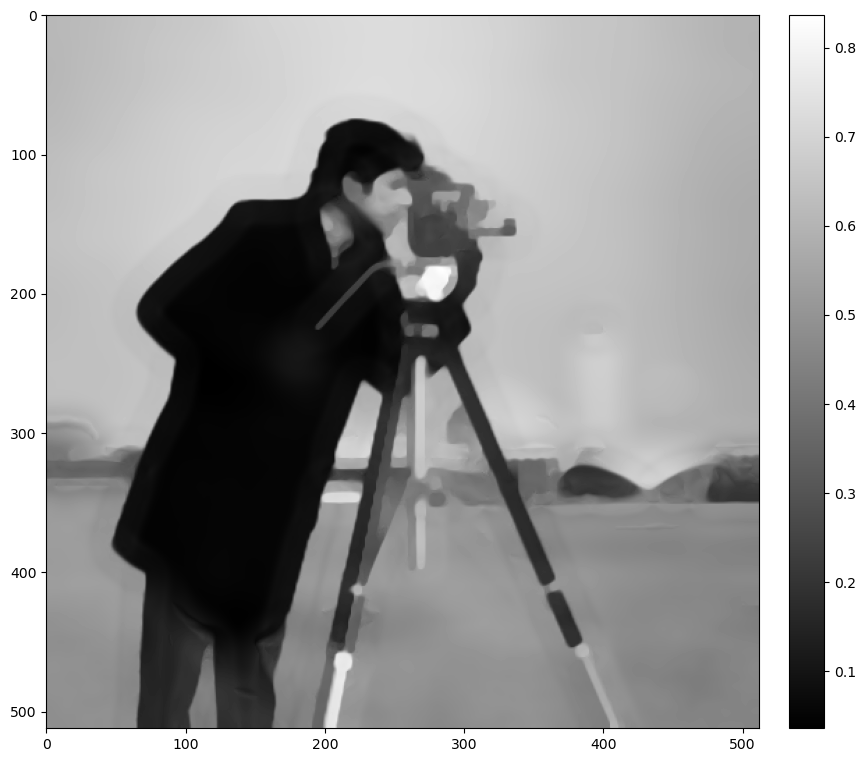

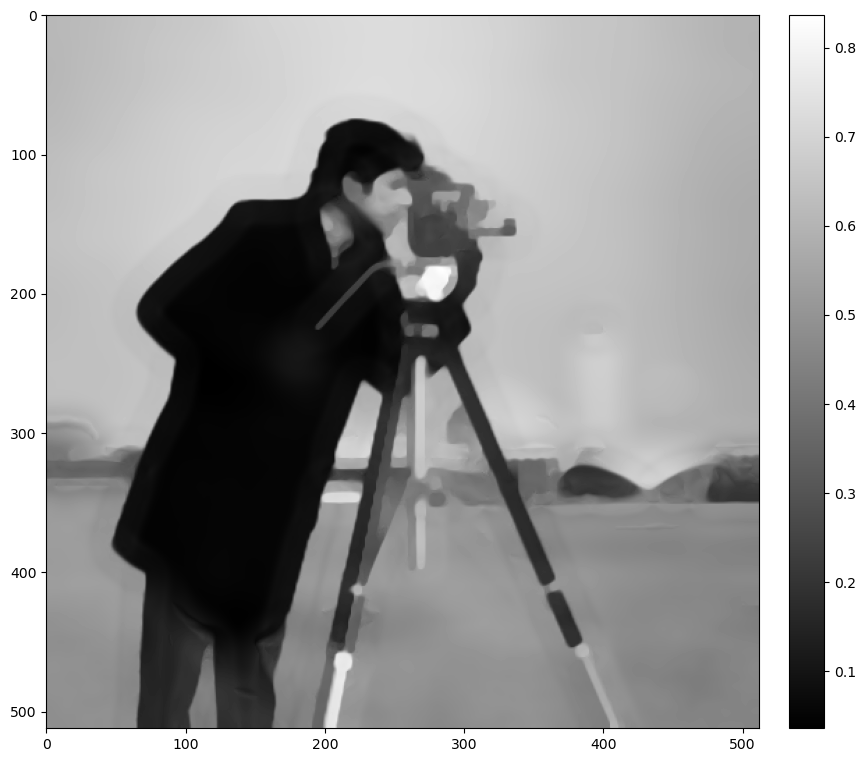

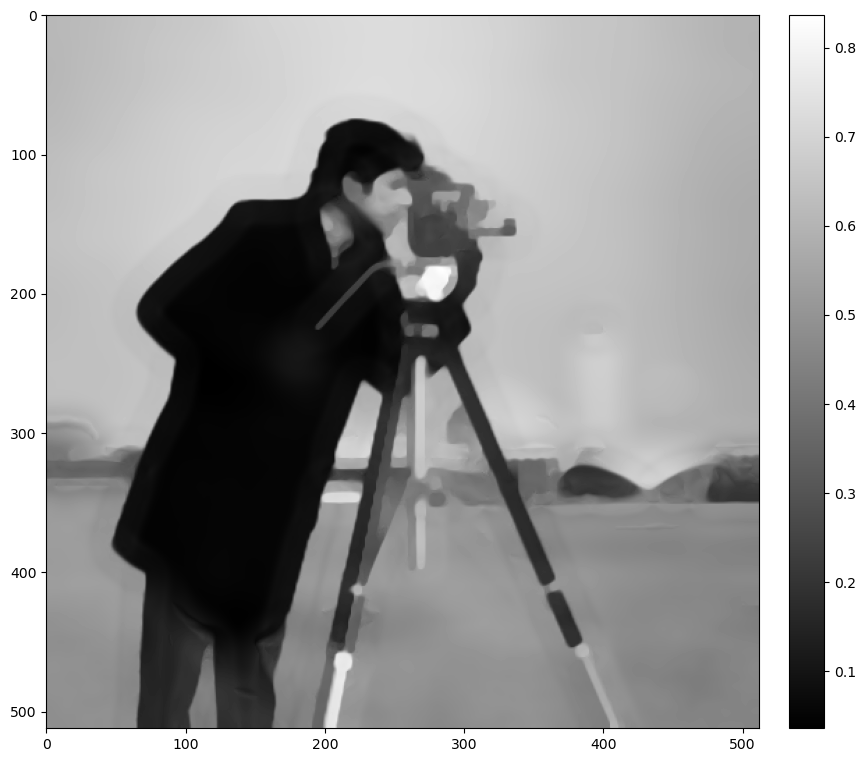

In [21]:
show2D(np.real(res.array[0]), origin="upper")
show2D(np.real(res.array[1]), origin="upper")
show2D(np.real(res.array[2]), origin="upper")